<a href="https://colab.research.google.com/github/sanntana21/TFG/blob/main/aggregated_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCIONES AGREGADAS**

In [1]:
print("v.0.1")

v.0.2
NECESITO QUE TE GUARDES


In [256]:
from tensorflow.keras import layers
import pandas as pd
from statistics import mean, median
import numpy as np
import pickle
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random as random
import plotly.express as px
import tensorflow as tf
import gzip

def set_output_precision(decimals):
  """
  format the output of the all the data structures
  with an specific number of decimals
  """
  np.set_printoptions(precision=decimals)
  into='{'+':.{}f'.format(decimals)+'}'
  pd.options.display.float_format = into.format
  pass

def plot_ts(df,dfx="Minute",dfy="METS",_title="DF minute x Mets"):
  if not isinstance(df,pd.DataFrame):
    df = pd.DataFrame({'METS': df, 'Minute': range(len(df))})

  plt.figure()
  fig = px.line(df, x = dfx, y = dfy , title = _title)
  fig.update_xaxes(
      rangeslider_visible = True,
      rangeselector = dict(
          buttons = list([
              dict(count=1,label="1y",step="year",stepmode="backward"),
              dict(count=2,label="2y",step="year",stepmode="backward"),
              dict(count=3,label="3y",step="year",stepmode="backward"),
              dict(step="all")
          ])
      )

  )
  fig.show()

def plot_predictions_vs_real(predictions, reals):
  df = pd.DataFrame()
  number_of_points = len(predictions)
  df["time"] = range(0,number_of_points)
  df["participant"] = "prediction"
  df["value"] = predictions
  for i in range(0,number_of_points):
    df.loc[number_of_points+i] = [i,"real",reals[i]]

  plt.figure(1)
  fig = px.line(df, x = "time", y = "value" , title = "predictions vs reals" , color = "participant")
  fig.update_xaxes(
        rangeslider_visible = True,
        rangeselector = dict(
            buttons = list([
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(count=2,label="2y",step="year",stepmode="backward"),
                dict(count=3,label="3y",step="year",stepmode="backward"),
                dict(step="all")
            ])
        )

    )
  fig.show()

'OLSResults'

In [257]:
INDEXS = [{"train":[{"start":{"day":2,"hour":0,"minute":0},
                     "end":{"day":21,"hour":22,"minute":0}}
                    ],
           "validation":[{"start":{"day":23,"hour":0,"minute":0},
                     "end":{"day":24,"hour":22,"minute":0}}
                    ],
           "test":[{"start":{"day":26,"hour":0,"minute":0},
                     "end":{"day":27,"hour":22,"minute":0}}
                    ]}
          ]

In [258]:
READ_LOCAL_DATA = True
COMPUTED_OPTION = 1
SAVE_RESULTS = False
LOW_DATA = True
SPLIT_INTO_TWO_DAYS = False
MULTI_STEP_FORECAST = False
np.random.seed(42)
tf.random.set_seed(42)
SPLIT = 0

In [259]:
if READ_LOCAL_DATA:
  PATH = "Resources/Individual/"
else:
    #  We start by getting access to the drive
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = "/content/drive/MyDrive/TFG/Resources/Agregado/"


if LOW_DATA:
    PATH += "LowData/"


In [261]:
import gzip
documents = ['minuteY','hourY','dayY']
# with open(PATH+"minuteX"+".pkl", 'rb') as file:
#     dataX = np.array(pickle.load(file),np.float32)
file = PATH+"minuteX.pkl.gz"
dataX = np.array(pickle.load(gzip.open(file, 'rb')),np.float32)

file = PATH+documents[COMPUTED_OPTION]+".pkl.gz"
dataY = np.array(pickle.load(gzip.open(file, 'rb')),np.float32)

dataX = np.sum(dataX,axis=0,keepdims=True)
dataY = np.sum(dataY,axis=0,keepdims=True)

In [262]:
if MULTI_STEP_FORECAST:
    PREDICTED_HORIZON = 1
    if COMPUTED_OPTION == 0:
        dataX_nuevo = dataX
        JUMP = 1
    elif COMPUTED_OPTION == 1:
        JUMP = 60
        dataX_nuevo = np.ones(shape=(dataX.shape[0],24))
        for i in range(0,dataX.shape[0]):
            for j in range(0,24):
                dataX_nuevo[i,j] = np.sum(dataX[i,60*j:60*(j+1)])
    else:
        JUMP = 1440
        dataX_nuevo = np.ones(shape=(dataX.shape[0],1))
        for i in range(0,dataX.shape[0]):
            dataX_nuevo[i,:] = np.sum(dataX[i,:])

In [263]:
#We split a test set for testing
# train_test_split(dataX, dataY, test_size=TEST_SIZE)

def calculate_index(time):
  minute_index = time["day"] * 1440 + time["hour"]*60 + time["minute"]
  return minute_index

def get_split(dataX,dataY,index):
  start = calculate_index(index[0]["start"])
  end = calculate_index(index[0]["end"])
  X_split = dataX[:,start:end,:]
  y_split = dataY[:,start:end,:]
  if len(index) > 1:
    for i in range(1,index):
      start = calculate_index(index[i]["start"])
      end = calculate_index(index[i]["end"])
      X_split = np.concatenate(X_split,dataX[:,start:end,:])
      y_split = np.concatenate(y_split,dataY[:,start:end,:])
  return X_split,y_split

def train_test_validation_split(dataX,dataY,indexs):
  X_train,y_train = get_split(dataX,dataY,indexs["train"])
  X_validation,y_validation = get_split(dataX,dataY,indexs["validation"])
  X_test,y_test = get_split(dataX,dataY,indexs["test"])
  return X_train,y_train,X_validation,y_validation,X_test,y_test


X_train,y_train,X_validation,y_validation,X_test,y_test = train_test_validation_split(dataX,dataY,INDEXS[SPLIT])
print("Examples for training\n","X:",X_train.shape,"y:",y_train.shape)
print("Examples for validation\n","X:",X_validation.shape,"y:",y_validation.shape)
print("Examples for test\n","X:",X_test.shape,"y:",y_test.shape)


Examples for training
 X: (1, 28560, 1440) y: (1, 28560, 2)
Examples for validation
 X: (1, 2760, 1440) y: (1, 2760, 2)
Examples for test
 X: (1, 2760, 1440) y: (1, 2760, 2)


In [274]:
#Quitamos en este caso la primera dimension
X_train,y_train,X_validation,y_validation,X_test,y_test = [
  np.squeeze(i) for i in [X_train,y_train,X_validation,y_validation,X_test,y_test]
]

print("Examples for training\n","X:",X_train.shape,"y:",y_train.shape)
print("Examples for validation\n","X:",X_validation.shape,"y:",y_validation.shape)
print("Examples for test\n","X:",X_test.shape,"y:",y_test.shape)

Examples for training
 X: (28560, 1440) y: (28560, 2)
Examples for validation
 X: (2760, 1440) y: (2760, 2)
Examples for test
 X: (2760, 1440) y: (2760, 2)


#**DEFINICION DEL MODELO**

In [275]:
tf.random.set_seed(42)
# Setup dataset hyperparameters
HORIZON = y_test.shape[1]
WINDOW_SIZE = X_test.shape[1]

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_LSTM = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_LSTM.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1440)]            0         
                                                                 
 lambda_9 (Lambda)           (None, 1, 1440)           0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               803328    
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 803,586
Trainable params: 803,586
Non-trainable params: 0
_________________________________________________________________


In [276]:
# Compile model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="auto"
)
model_LSTM.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
             metrics=["mae"])


In [277]:
# # Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
hist = model_LSTM.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=256,
            validation_data=(X_validation, y_validation),
               callbacks=[early_stopping])

Epoch 1/100
112/112 [==============================] - 2s 13ms/step - loss: 381.1272 - mae: 381.1272 - val_loss: 164.7333 - val_mae: 164.7333
Epoch 2/100
112/112 [==============================] - 1s 12ms/step - loss: 149.8680 - mae: 149.8680 - val_loss: 139.1928 - val_mae: 139.1928
Epoch 3/100
112/112 [==============================] - 1s 12ms/step - loss: 133.6018 - mae: 133.6018 - val_loss: 117.9420 - val_mae: 117.9420
Epoch 4/100
112/112 [==============================] - 1s 12ms/step - loss: 122.6401 - mae: 122.6401 - val_loss: 115.2521 - val_mae: 115.2521
Epoch 5/100
112/112 [==============================] - 1s 12ms/step - loss: 117.5422 - mae: 117.5422 - val_loss: 106.8675 - val_mae: 106.8675
Epoch 6/100
112/112 [==============================] - 1s 11ms/step - loss: 113.6149 - mae: 113.6149 - val_loss: 110.4204 - val_mae: 110.4204
Epoch 7/100
112/112 [==============================] - 1s 12ms/step - loss: 110.5024 - mae: 110.5024 - val_loss: 115.0534 - val_mae: 115.0534
Epoch 

In [278]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data,verbose=2)
  return tf.squeeze(forecast) # return 1D array of predictions

predictions = make_preds(model_LSTM, X_test)

87/87 - 0s - 312ms/epoch - 4ms/step


In [279]:
print("Resultados comparando directamente las salidas")
print(y_test.shape)
print(predictions.shape)
print('\033[1m' + "MSE: " + str(mean_squared_error(y_test,predictions)) + '\033[0m')
print('\033[1m' + "MAE: " + str(mean_absolute_error(y_test,predictions)) + '\033[0m')
print(np.mean(y_test))

Resultados comparando directamente las salidas
(2760, 2)
(2760, 2)
MSE: 17845.96
MAE: 101.04845
2446.6475


In [280]:
SPLIT_INTO_TWO_DAYS = True
if not MULTI_STEP_FORECAST:
  print("Resultados poblacionales cada dos horas")
  print('\033[1m' + "MSE: " + str(mean_squared_error(np.sum(y_test,axis=1),np.sum(predictions,axis=1))) + '\033[0m')
  print('\033[1m' + "MAE: " + str(mean_absolute_error(np.sum(y_test,axis=1),np.sum(predictions,axis=1))) + '\033[0m')
  print("Ejemplos aleatorios")
  list_of_MAE = [  mean_absolute_error(predictions[i],y_test[i]) for i in range(0,len(y_test)) ]
  list_of_values = sorted(list_of_MAE)
  mean_value = mean(list_of_MAE)
  closest_value = min(list_of_MAE, key=lambda x: abs(x - mean_value))
  # Crear un array de índices
  indices = [list_of_MAE.index(list_of_values[-1]),
             list_of_MAE.index(closest_value) ,
            list_of_MAE.index(list_of_values[0])]
  if COMPUTED_OPTION == 0:
    for i in indices:
      print(list_of_MAE[i])
      plot_predictions_vs_real(predictions[i],y_test[i])
  else:
    for i in indices:
        print(list_of_MAE[i])
        END = 24
        STARTED_MINUTE = 0
        previous = np.ones(shape=(24))
        for j in range(0,24):
            previous[j] = np.sum(X_test[i,:][60*j:60*(j+1)])
        predictions_to_plot = np.ones(shape=(END + HORIZON))
        predictions_to_plot[0:END] = previous[:]
        predictions_to_plot[END:] = predictions[i,:]
        y_test_to_plot = np.ones(shape=(END + HORIZON))
        y_test_to_plot[0:END] = previous[:]
        y_test_to_plot[END:] = y_test[i,:]
        plot_predictions_vs_real(predictions_to_plot,y_test_to_plot)

  if SPLIT_INTO_TWO_DAYS:
      index = 0
      period = X_test[::120,:]
      period_results = make_preds(model_LSTM,period)
      period_results_to_plot = np.array(period_results).reshape(HORIZON*23)
      y_test_to_plot = y_test[::120,:].reshape(HORIZON*23)
      plot_predictions_vs_real(predictions=period_results_to_plot,reals=y_test_to_plot)
      print('\033[1m' + "Predicted: " + str(np.sum(period_results_to_plot)) + '\033[0m')
      print('\033[1m' + "Reals: " + str(np.sum(y_test_to_plot)) + '\033[0m')


Resultados poblacionales cada dos horas
MSE: 55876.375
MAE: 180.48582
Ejemplos aleatorios


1/1 - 0s - 28ms/epoch - 28ms/step
Predicted: 110512.4
Reals: 112477.52


[548.62956271   0.75815529]


<Figure size 640x480 with 0 Axes>

In [281]:
if MULTI_STEP_FORECAST:
    day_before = np.array(X_test[0:1,:],dtype=np.float32)
    predicted_values_day_one = np.ones(shape=(WINDOW_SIZE,1),dtype=np.float32)
    for i in range(0,WINDOW_SIZE):
        prediction = float(make_preds(model_LSTM, day_before))
        day_before[:,0:-1] = day_before[:,1:]
        day_before[:,-1] = prediction
        predicted_values_day_one[i,0] = prediction

    SECOND_DAY = X_test.shape[1]
    day_before = np.array(X_test[SECOND_DAY:SECOND_DAY+1,:],dtype=np.float32)
    predicted_values_day_two = np.ones(shape=(WINDOW_SIZE,1),dtype=np.float32)
    for i in range(0,WINDOW_SIZE):
        prediction = float(make_preds(model_LSTM, day_before))
        day_before[:,0:-1] = day_before[:,1:]
        day_before[:,-1] = prediction
        predicted_values_day_two[i,0] = prediction

In [282]:
if MULTI_STEP_FORECAST:
    print("Predecidos : " + str(int(np.sum(predicted_values_day_one[:,0]))))
    print("Reales : " + str(int(np.sum(y_test[0:WINDOW_SIZE,0]))))
    if COMPUTED_OPTION < 2:
        plot_predictions_vs_real(predicted_values_day_one[:,0],y_test[0:WINDOW_SIZE,0])

In [283]:
if MULTI_STEP_FORECAST:
    print("Predecidos : " + str(int(np.sum(predicted_values_day_two[:,0]))))
    print("Reales : " + str(int(np.sum(y_test[SECOND_DAY:,0]))))
    if COMPUTED_OPTION < 2:
        plot_predictions_vs_real(predicted_values_day_two[:,0],y_test[SECOND_DAY:,0])

In [284]:
SAVE_RESULTS = True
if SAVE_RESULTS:
  if READ_LOCAL_DATA:
    file_path = 'Resources/Resultados/Agregado/'
  else:
    file_path = "/content/drive/MyDrive/TFG/Resources/Resultados/Agregado/"
    if LOW_DATA:
        file_path += "LowData/"

    file_path += "Split"+str(SPLIT)
    documents = ['minuteY','hourY','dayY']
    file = file_path+documents[COMPUTED_OPTION]+"-predictions"+".pkl.gz"
    pickle.dump(predictions, gzip.open(file, 'wb'))
    file = file_path+documents[COMPUTED_OPTION]+"-test"+".pkl.gz"
    pickle.dump(y_test, gzip.open(file, 'wb'))
    file = file_path+documents[COMPUTED_OPTION]+"-X"+".pkl.gz"
    pickle.dump(X_test, gzip.open(file, 'wb'))

True
101.04845
save_results
GUARDATEEE
Resources/Resultados/Agregado/LowData/Split3


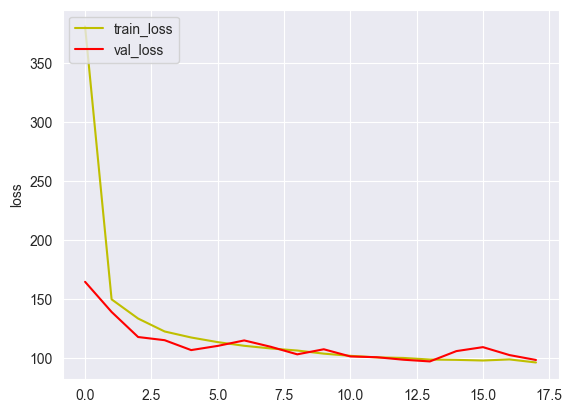

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history["loss"], "y", label = "train_loss")
loss_ax.plot(hist.history["val_loss"], "r", label = "val_loss")


loss_ax.set_ylabel("loss")

loss_ax.legend(loc = "upper left")

plt.show()